# Edit SNPE-C to do non-atomic! Try RNN

In [2]:
# Import Libraries
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

import torch

from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

In [3]:
from typing import Callable, Dict, Optional, Union

import torch
from pyknos.mdn.mdn import MultivariateGaussianMDN as mdn
from pyknos.nflows.transforms import CompositeTransform
from torch import Tensor, eye, nn, ones
from torch.distributions import Distribution, MultivariateNormal, Uniform

from sbi import utils as utils
from sbi.inference.posteriors.direct_posterior import DirectPosterior
from sbi.inference.snpe.snpe_base import PosteriorEstimator
from sbi.types import TensorboardSummaryWriter
from sbi.utils import (
    batched_mixture_mv,
    batched_mixture_vmv,
    check_dist_class,
    clamp_and_warn,
    del_entries,
    repeat_rows,
)


class SNPE_C(PosteriorEstimator):
    def __init__(
        self,
        prior: Optional[Distribution] = None,
        density_estimator: Union[str, Callable] = "maf",
        device: str = "cpu",
        logging_level: Union[int, str] = "WARNING",
        summary_writer: Optional[TensorboardSummaryWriter] = None,
        show_progress_bars: bool = True,
    ):
        r"""SNPE-C / APT [1].

        [1] _Automatic Posterior Transformation for Likelihood-free Inference_,
            Greenberg et al., ICML 2019, https://arxiv.org/abs/1905.07488.

        This class implements two loss variants of SNPE-C: the non-atomic and the atomic
        version. The atomic loss of SNPE-C can be used for any density estimator,
        i.e. also for normalizing flows. However, it suffers from leakage issues. On
        the other hand, the non-atomic loss can only be used only if the proposal
        distribution is a mixture of Gaussians, the density estimator is a mixture of
        Gaussians, and the prior is either Gaussian or Uniform. It does not suffer from
        leakage issues. At the beginning of each round, we print whether the non-atomic
        or the atomic version is used.

        In this codebase, we will automatically switch to the non-atomic loss if the
        following criteria are fulfilled:<br/>
        - proposal is a `DirectPosterior` with density_estimator `mdn`, as built
            with `utils.sbi.posterior_nn()`.<br/>
        - the density estimator is a `mdn`, as built with
            `utils.sbi.posterior_nn()`.<br/>
        - `isinstance(prior, MultivariateNormal)` (from `torch.distributions`) or
            `isinstance(prior, sbi.utils.BoxUniform)`

        Note that custom implementations of any of these densities (or estimators) will
        not trigger the non-atomic loss, and the algorithm will fall back onto using
        the atomic loss.

        Args:
            prior: A probability distribution that expresses prior knowledge about the
                parameters, e.g. which ranges are meaningful for them.
            density_estimator: If it is a string, use a pre-configured network of the
                provided type (one of nsf, maf, mdn, made). Alternatively, a function
                that builds a custom neural network can be provided. The function will
                be called with the first batch of simulations (theta, x), which can
                thus be used for shape inference and potentially for z-scoring. It
                needs to return a PyTorch `nn.Module` implementing the density
                estimator. The density estimator needs to provide the methods
                `.log_prob` and `.sample()`.
            device: Training device, e.g., "cpu", "cuda" or "cuda:{0, 1, ...}".
            logging_level: Minimum severity of messages to log. One of the strings
                INFO, WARNING, DEBUG, ERROR and CRITICAL.
            summary_writer: A tensorboard `SummaryWriter` to control, among others, log
                file location (default is `<current working directory>/logs`.)
            show_progress_bars: Whether to show a progressbar during training.
        """

        kwargs = del_entries(locals(), entries=("self", "__class__"))
        super().__init__(**kwargs)

    def train(
        self,
        num_atoms: int = 10,
        training_batch_size: int = 50,
        learning_rate: float = 5e-4,
        validation_fraction: float = 0.1,
        stop_after_epochs: int = 20,
        max_num_epochs: int = 2**31 - 1,
        clip_max_norm: Optional[float] = 5.0,
        calibration_kernel: Optional[Callable] = None,
        resume_training: bool = False,
        force_first_round_loss: bool = False,
        discard_prior_samples: bool = False,
        use_combined_loss: bool = False,
        retrain_from_scratch: bool = False,
        show_train_summary: bool = False,
        dataloader_kwargs: Optional[Dict] = None,
    ) -> nn.Module:
        r"""Return density estimator that approximates the distribution $p(\theta|x)$.

        Args:
            num_atoms: Number of atoms to use for classification.
            training_batch_size: Training batch size.
            learning_rate: Learning rate for Adam optimizer.
            validation_fraction: The fraction of data to use for validation.
            stop_after_epochs: The number of epochs to wait for improvement on the
                validation set before terminating training.
            max_num_epochs: Maximum number of epochs to run. If reached, we stop
                training even when the validation loss is still decreasing. Otherwise,
                we train until validation loss increases (see also `stop_after_epochs`).
            clip_max_norm: Value at which to clip the total gradient norm in order to
                prevent exploding gradients. Use None for no clipping.
            calibration_kernel: A function to calibrate the loss with respect to the
                simulations `x`. See Lueckmann, Gonçalves et al., NeurIPS 2017.
            resume_training: Can be used in case training time is limited, e.g. on a
                cluster. If `True`, the split between train and validation set, the
                optimizer, the number of epochs, and the best validation log-prob will
                be restored from the last time `.train()` was called.
            force_first_round_loss: If `True`, train with maximum likelihood,
                i.e., potentially ignoring the correction for using a proposal
                distribution different from the prior.
            discard_prior_samples: Whether to discard samples simulated in round 1, i.e.
                from the prior. Training may be sped up by ignoring such less targeted
                samples.
            use_combined_loss: Whether to train the neural net also on prior samples
                using maximum likelihood in addition to training it on all samples using
                atomic loss. The extra MLE loss helps prevent density leaking with
                bounded priors.
            retrain_from_scratch: Whether to retrain the conditional density
                estimator for the posterior from scratch each round.
            show_train_summary: Whether to print the number of epochs and validation
                loss and leakage after the training.
            dataloader_kwargs: Additional or updated kwargs to be passed to the training
                and validation dataloaders (like, e.g., a collate_fn)

        Returns:
            Density estimator that approximates the distribution $p(\theta|x)$.
        """

        # WARNING: sneaky trick ahead. We proxy the parent's `train` here,
        # requiring the signature to have `num_atoms`, save it for use below, and
        # continue. It's sneaky because we are using the object (self) as a namespace
        # to pass arguments between functions, and that's implicit state management.
        self._num_atoms = num_atoms
        self._use_combined_loss = use_combined_loss
        kwargs = del_entries(
            locals(),
            entries=("self", "__class__", "num_atoms", "use_combined_loss"),
        )

        self._round = max(self._data_round_index)

        if self._round > 0:
            # Set the proposal to the last proposal that was passed by the user. For
            # atomic SNPE, it does not matter what the proposal is. For non-atomic
            # SNPE, we only use the latest data that was passed, i.e. the one from the
            # last proposal.
            proposal = self._proposal_roundwise[-1]
            self.use_non_atomic_loss = (
                isinstance(proposal, DirectPosterior)
                and isinstance(proposal.posterior_estimator._distribution, mdn)
                and isinstance(self._neural_net._distribution, mdn)
                and check_dist_class(
                    self._prior, class_to_check=(Uniform, MultivariateNormal)
                )[0]
            )

            #algorithm = "non-atomic" if self.use_non_atomic_loss else "atomic"
            #print(f"Using SNPE-C with {algorithm} loss")

            algorithm = "non-atomic" #Just use atomic!
            print(f"Using SNPE-C with {algorithm} loss")

            if self.use_non_atomic_loss:
                # Take care of z-scoring, pre-compute and store prior terms.
                self._set_state_for_mog_proposal()

        return super().train(**kwargs)

    def _set_state_for_mog_proposal(self) -> None:
        """Set state variables that are used at each training step of non-atomic SNPE-C.

        Three things are computed:
        1) Check if z-scoring was requested. To do so, we check if the `_transform`
            argument of the net had been a `CompositeTransform`. See pyknos mdn.py.
        2) Define a (potentially standardized) prior. It's standardized if z-scoring
            had been requested.
        3) Compute (Precision * mean) for the prior. This quantity is used at every
            training step if the prior is Gaussian.
        """

        self.z_score_theta = isinstance(self._neural_net._transform, CompositeTransform)

        self._set_maybe_z_scored_prior()

        if isinstance(self._maybe_z_scored_prior, MultivariateNormal):
            self.prec_m_prod_prior = torch.mv(
                self._maybe_z_scored_prior.precision_matrix,  # type: ignore
                self._maybe_z_scored_prior.loc,  # type: ignore
            )

    def _set_maybe_z_scored_prior(self) -> None:
        r"""Compute and store potentially standardized prior (if z-scoring was done).

        The proposal posterior is:
        $pp(\theta|x) = 1/Z * q(\theta|x) * prop(\theta) / p(\theta)$

        Let's denote z-scored theta by `a`: a = (theta - mean) / std
        Then pp'(a|x) = 1/Z_2 * q'(a|x) * prop'(a) / p'(a)$

        The ' indicates that the evaluation occurs in standardized space. The constant
        scaling factor has been absorbed into Z_2.
        From the above equation, we see that we need to evaluate the prior **in
        standardized space**. We build the standardized prior in this function.

        The standardize transform that is applied to the samples theta does not use
        the exact prior mean and std (due to implementation issues). Hence, the z-scored
        prior will not be exactly have mean=0 and std=1.
        """

        if self.z_score_theta:
            scale = self._neural_net._transform._transforms[0]._scale
            shift = self._neural_net._transform._transforms[0]._shift

            # Following the definintion of the linear transform in
            # `standardizing_transform` in `sbiutils.py`:
            # shift=-mean / std
            # scale=1 / std
            # Solving these equations for mean and std:
            estim_prior_std = 1 / scale
            estim_prior_mean = -shift * estim_prior_std

            # Compute the discrepancy of the true prior mean and std and the mean and
            # std that was empirically estimated from samples.
            # N(theta|m,s) = N((theta-m_e)/s_e|(m-m_e)/s_e, s/s_e)
            # Above: m,s are true prior mean and std. m_e,s_e are estimated prior mean
            # and std (estimated from samples and used to build standardize transform).
            almost_zero_mean = (self._prior.mean - estim_prior_mean) / estim_prior_std
            almost_one_std = torch.sqrt(self._prior.variance) / estim_prior_std

            if isinstance(self._prior, MultivariateNormal):
                self._maybe_z_scored_prior = MultivariateNormal(
                    almost_zero_mean, torch.diag(almost_one_std)
                )
            else:
                range_ = torch.sqrt(almost_one_std * 3.0)
                self._maybe_z_scored_prior = utils.BoxUniform(
                    almost_zero_mean - range_, almost_zero_mean + range_
                )
        else:
            self._maybe_z_scored_prior = self._prior

    def _log_prob_proposal_posterior(
        self,
        theta: Tensor,
        x: Tensor,
        masks: Tensor,
        proposal: DirectPosterior,
    ) -> Tensor:
        """Return the log-probability of the proposal posterior.

        If the proposal is a MoG, the density estimator is a MoG, and the prior is
        either Gaussian or uniform, we use non-atomic loss. Else, use atomic loss (which
        suffers from leakage).

        Args:
            theta: Batch of parameters θ.
            x: Batch of data.
            masks: Mask that is True for prior samples in the batch in order to train
                them with prior loss.
            proposal: Proposal distribution.

        Returns: Log-probability of the proposal posterior.
        """

        if self.use_non_atomic_loss:
            return self._log_prob_proposal_posterior_mog(theta, x, proposal)
        else:
            return self._log_prob_proposal_posterior_atomic(theta, x, masks)

    def _log_prob_proposal_posterior_atomic(
        self, theta: Tensor, x: Tensor, masks: Tensor
    ):
        """Return log probability of the proposal posterior for atomic proposals.

        We have two main options when evaluating the proposal posterior.
            (1) Generate atoms from the proposal prior.
            (2) Generate atoms from a more targeted distribution, such as the most
                recent posterior.
        If we choose the latter, it is likely beneficial not to do this in the first
        round, since we would be sampling from a randomly-initialized neural density
        estimator.

        Args:
            theta: Batch of parameters θ.
            x: Batch of data.
            masks: Mask that is True for prior samples in the batch in order to train
                them with prior loss.

        Returns:
            Log-probability of the proposal posterior.
        """

        batch_size = theta.shape[0]

        num_atoms = int(
            clamp_and_warn("num_atoms", self._num_atoms, min_val=2, max_val=batch_size)
        )

        # Each set of parameter atoms is evaluated using the same x,
        # so we repeat rows of the data x, e.g. [1, 2] -> [1, 1, 2, 2]
        repeated_x = repeat_rows(x, num_atoms)

        # To generate the full set of atoms for a given item in the batch,
        # we sample without replacement num_atoms - 1 times from the rest
        # of the theta in the batch.
        probs = ones(batch_size, batch_size) * (1 - eye(batch_size)) / (batch_size - 1)

        choices = torch.multinomial(probs, num_samples=num_atoms - 1, replacement=False)
        contrasting_theta = theta[choices]

        # We can now create our sets of atoms from the contrasting parameter sets
        # we have generated.
        atomic_theta = torch.cat((theta[:, None, :], contrasting_theta), dim=1).reshape(
            batch_size * num_atoms, -1
        )

        # Evaluate large batch giving (batch_size * num_atoms) log prob posterior evals.
        log_prob_posterior = self._neural_net.log_prob(atomic_theta, repeated_x)
        utils.assert_all_finite(log_prob_posterior, "posterior eval")
        log_prob_posterior = log_prob_posterior.reshape(batch_size, num_atoms)

        # Get (batch_size * num_atoms) log prob prior evals.
        log_prob_prior = self._prior.log_prob(atomic_theta)
        log_prob_prior = log_prob_prior.reshape(batch_size, num_atoms)
        utils.assert_all_finite(log_prob_prior, "prior eval")

        # Compute unnormalized proposal posterior.
        unnormalized_log_prob = log_prob_posterior - log_prob_prior

        # Normalize proposal posterior across discrete set of atoms.
        log_prob_proposal_posterior = unnormalized_log_prob[:, 0] - torch.logsumexp(
            unnormalized_log_prob, dim=-1
        )
        utils.assert_all_finite(log_prob_proposal_posterior, "proposal posterior eval")

        # XXX This evaluates the posterior on _all_ prior samples
        if self._use_combined_loss:
            log_prob_posterior_non_atomic = self._neural_net.log_prob(theta, x)
            masks = masks.reshape(-1)
            log_prob_proposal_posterior = (
                masks * log_prob_posterior_non_atomic + log_prob_proposal_posterior
            )

        return log_prob_proposal_posterior

In [8]:
#Code simulator and everything else as always
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the model
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, k2, k3 = params

    dm1dt = -m1 + (10 ** 3 / (1 + (10 ** k1 * p2) ** 2)) + 1
    dp1dt = -10 ** 0 * (p1 - m1)

    dm2dt = -m2 + (10 ** 3 / (1 + (10 ** k2 * p3) ** 2)) + 1
    dp2dt = -10 ** 0 * (p2 - m2)

    dm3dt = -m3 + (10 ** 3 / (1 + (10 ** k3 * p1) ** 2)) + 1
    dp3dt = -10 ** 0 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

#Define true parameters
true_params = np.array([
    0, 0, 0  # first set of odes
])

num_timesteps = 1000  # Number of time steps for simulation

num_dim = 3
num_timesteps = 1000
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))
num_trajectories = 6

#INVERSE! 6X1000!

def simulator(parameter_set):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    traj = torch.zeros((num_timesteps, num_trajectories))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[timestep, i] = solution[timestep][i]
    return traj

true_data = simulator(true_params)
true_data

tensor([[  0.0000,   1.0000,   0.0000,   3.0000,   0.0000,   2.0000],
        [  8.9123,   1.3648,  12.9051,   3.4811,  42.9083,   4.0501],
        [ 13.8703,   2.3506,  14.4150,   4.4862,  61.6269,   8.8289],
        ...,
        [ 46.9959, 113.7526,  56.8882,  25.9989,   1.2610,   2.7314],
        [ 42.7398, 107.1846,  63.3755,  29.2513,   1.2439,   2.5905],
        [ 38.8630, 100.8554,  70.3635,  32.8362,   1.2295,   2.4615]])

In [6]:
#We have 1000 timepoints and 6 dimensions
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=False) #We are not specifying a batch size
        self.linear = nn.Linear(hidden_size, output_size)

                                                       #The middle value needs to be the length, in this case 1000, or input.size(0) (try with true_data)
                                                        #1 is the number of layers
                                                        #Actually prepare for sbi adds a batch_size, so x.shape is (1, 1000, 6)
    def forward(self, x):
        h = torch.zeros(1, 1000, self.hidden_size)
        gru_out, _ = self.gru(
            x, h)
        output = self.linear(gru_out[:, -1, :])
        return output

# Example usage
input_size = 6 #Needs to be the same as input.size(-1)
output_size = 25
hidden_size = 100
embedding_net = RNN(input_size, hidden_size, output_size)


In [7]:
# set prior distribution for the parameters
num_dim = 3
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))

# 3 rounds: first round simulates from the prior, second round simulates parameter set
# that were sampled from the obtained posterior.
num_rounds = 2

# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(
    model="mdn", embedding_net=embedding_net, hidden_features=10, num_transforms=2
)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)

posteriors = []
proposal = prior

for _ in range(num_rounds):
    simulator, prior = prepare_for_sbi(simulator, prior)
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=100)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(true_data)

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 233 epochs.

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with non-atomic loss
 Neural network successfully converged after 30 epochs.

In [10]:
posteriors[0]

DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

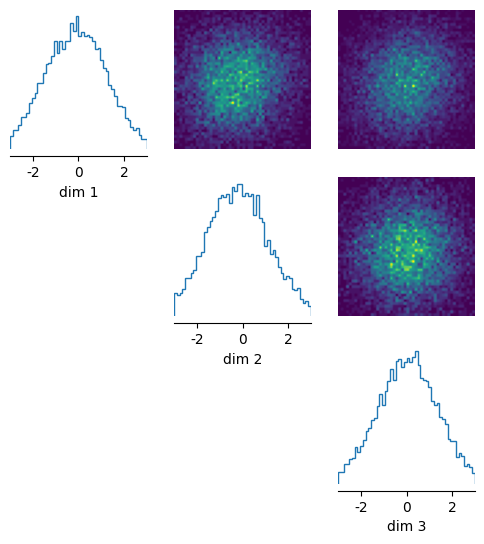

In [11]:
posterior_samples = posterior.sample((10000,), x=true_data)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[-3, 3], [-3, 3], [-3, 3]], figsize=(6, 6)
)

# non-atomic loss does the job?

In [2]:
from typing import Callable, Dict, Optional, Union

import torch
from pyknos.mdn.mdn import MultivariateGaussianMDN as mdn
from pyknos.nflows.transforms import CompositeTransform
from torch import Tensor, eye, nn, ones
from torch.distributions import Distribution, MultivariateNormal, Uniform

from sbi import utils as utils
from sbi.inference.posteriors.direct_posterior import DirectPosterior
from sbi.inference.snpe.snpe_base import PosteriorEstimator
from sbi.types import TensorboardSummaryWriter
from sbi.utils import (
    batched_mixture_mv,
    batched_mixture_vmv,
    check_dist_class,
    clamp_and_warn,
    del_entries,
    repeat_rows,
)


class SNPE_C(PosteriorEstimator):
    def __init__(
        self,
        prior: Optional[Distribution] = None,
        density_estimator: Union[str, Callable] = "maf",
        device: str = "cpu",
        logging_level: Union[int, str] = "WARNING",
        summary_writer: Optional[TensorboardSummaryWriter] = None,
        show_progress_bars: bool = True,
    ):
        r"""SNPE-C / APT [1].

        [1] _Automatic Posterior Transformation for Likelihood-free Inference_,
            Greenberg et al., ICML 2019, https://arxiv.org/abs/1905.07488.

        This class implements two loss variants of SNPE-C: the non-atomic and the atomic
        version. The atomic loss of SNPE-C can be used for any density estimator,
        i.e. also for normalizing flows. However, it suffers from leakage issues. On
        the other hand, the non-atomic loss can only be used only if the proposal
        distribution is a mixture of Gaussians, the density estimator is a mixture of
        Gaussians, and the prior is either Gaussian or Uniform. It does not suffer from
        leakage issues. At the beginning of each round, we print whether the non-atomic
        or the atomic version is used.

        In this codebase, we will automatically switch to the non-atomic loss if the
        following criteria are fulfilled:<br/>
        - proposal is a `DirectPosterior` with density_estimator `mdn`, as built
            with `utils.sbi.posterior_nn()`.<br/>
        - the density estimator is a `mdn`, as built with
            `utils.sbi.posterior_nn()`.<br/>
        - `isinstance(prior, MultivariateNormal)` (from `torch.distributions`) or
            `isinstance(prior, sbi.utils.BoxUniform)`

        Note that custom implementations of any of these densities (or estimators) will
        not trigger the non-atomic loss, and the algorithm will fall back onto using
        the atomic loss.

        Args:
            prior: A probability distribution that expresses prior knowledge about the
                parameters, e.g. which ranges are meaningful for them.
            density_estimator: If it is a string, use a pre-configured network of the
                provided type (one of nsf, maf, mdn, made). Alternatively, a function
                that builds a custom neural network can be provided. The function will
                be called with the first batch of simulations (theta, x), which can
                thus be used for shape inference and potentially for z-scoring. It
                needs to return a PyTorch `nn.Module` implementing the density
                estimator. The density estimator needs to provide the methods
                `.log_prob` and `.sample()`.
            device: Training device, e.g., "cpu", "cuda" or "cuda:{0, 1, ...}".
            logging_level: Minimum severity of messages to log. One of the strings
                INFO, WARNING, DEBUG, ERROR and CRITICAL.
            summary_writer: A tensorboard `SummaryWriter` to control, among others, log
                file location (default is `<current working directory>/logs`.)
            show_progress_bars: Whether to show a progressbar during training.
        """

        kwargs = del_entries(locals(), entries=("self", "__class__"))
        super().__init__(**kwargs)

    def train(
        self,
        num_atoms: int = 10,
        training_batch_size: int = 50,
        learning_rate: float = 5e-4,
        validation_fraction: float = 0.1,
        stop_after_epochs: int = 20,
        max_num_epochs: int = 2**31 - 1,
        clip_max_norm: Optional[float] = 5.0,
        calibration_kernel: Optional[Callable] = None,
        resume_training: bool = False,
        force_first_round_loss: bool = False,
        discard_prior_samples: bool = False,
        use_combined_loss: bool = False,
        retrain_from_scratch: bool = False,
        show_train_summary: bool = False,
        dataloader_kwargs: Optional[Dict] = None,
    ) -> nn.Module:
        r"""Return density estimator that approximates the distribution $p(\theta|x)$.

        Args:
            num_atoms: Number of atoms to use for classification.
            training_batch_size: Training batch size.
            learning_rate: Learning rate for Adam optimizer.
            validation_fraction: The fraction of data to use for validation.
            stop_after_epochs: The number of epochs to wait for improvement on the
                validation set before terminating training.
            max_num_epochs: Maximum number of epochs to run. If reached, we stop
                training even when the validation loss is still decreasing. Otherwise,
                we train until validation loss increases (see also `stop_after_epochs`).
            clip_max_norm: Value at which to clip the total gradient norm in order to
                prevent exploding gradients. Use None for no clipping.
            calibration_kernel: A function to calibrate the loss with respect to the
                simulations `x`. See Lueckmann, Gonçalves et al., NeurIPS 2017.
            resume_training: Can be used in case training time is limited, e.g. on a
                cluster. If `True`, the split between train and validation set, the
                optimizer, the number of epochs, and the best validation log-prob will
                be restored from the last time `.train()` was called.
            force_first_round_loss: If `True`, train with maximum likelihood,
                i.e., potentially ignoring the correction for using a proposal
                distribution different from the prior.
            discard_prior_samples: Whether to discard samples simulated in round 1, i.e.
                from the prior. Training may be sped up by ignoring such less targeted
                samples.
            use_combined_loss: Whether to train the neural net also on prior samples
                using maximum likelihood in addition to training it on all samples using
                atomic loss. The extra MLE loss helps prevent density leaking with
                bounded priors.
            retrain_from_scratch: Whether to retrain the conditional density
                estimator for the posterior from scratch each round.
            show_train_summary: Whether to print the number of epochs and validation
                loss and leakage after the training.
            dataloader_kwargs: Additional or updated kwargs to be passed to the training
                and validation dataloaders (like, e.g., a collate_fn)

        Returns:
            Density estimator that approximates the distribution $p(\theta|x)$.
        """

        # WARNING: sneaky trick ahead. We proxy the parent's `train` here,
        # requiring the signature to have `num_atoms`, save it for use below, and
        # continue. It's sneaky because we are using the object (self) as a namespace
        # to pass arguments between functions, and that's implicit state management.
        self._num_atoms = num_atoms
        self._use_combined_loss = use_combined_loss
        kwargs = del_entries(
            locals(),
            entries=("self", "__class__", "num_atoms", "use_combined_loss"),
        )

        self._round = max(self._data_round_index)

        if self._round > 0:
            # Set the proposal to the last proposal that was passed by the user. For
            # atomic SNPE, it does not matter what the proposal is. For non-atomic
            # SNPE, we only use the latest data that was passed, i.e. the one from the
            # last proposal.
            proposal = self._proposal_roundwise[-1]
            self.use_non_atomic_loss = (
                isinstance(proposal, DirectPosterior)
                and isinstance(proposal.posterior_estimator._distribution, mdn)
                and isinstance(self._neural_net._distribution, mdn)
                and check_dist_class(
                    self._prior, class_to_check=(Uniform, MultivariateNormal)
                )[0]
            )

            #algorithm = "non-atomic" if self.use_non_atomic_loss else "atomic"
            #print(f"Using SNPE-C with {algorithm} loss")

            algorithm = "non-atomic" #Just use atomic!
            print(f"Using SNPE-C with {algorithm} loss")

            if self.use_non_atomic_loss:
                # Take care of z-scoring, pre-compute and store prior terms.
                self._set_state_for_mog_proposal()

        return super().train(**kwargs)

    def _set_state_for_mog_proposal(self) -> None:
        """Set state variables that are used at each training step of non-atomic SNPE-C.

        Three things are computed:
        1) Check if z-scoring was requested. To do so, we check if the `_transform`
            argument of the net had been a `CompositeTransform`. See pyknos mdn.py.
        2) Define a (potentially standardized) prior. It's standardized if z-scoring
            had been requested.
        3) Compute (Precision * mean) for the prior. This quantity is used at every
            training step if the prior is Gaussian.
        """

        self.z_score_theta = isinstance(self._neural_net._transform, CompositeTransform)

        self._set_maybe_z_scored_prior()

        if isinstance(self._maybe_z_scored_prior, MultivariateNormal):
            self.prec_m_prod_prior = torch.mv(
                self._maybe_z_scored_prior.precision_matrix,  # type: ignore
                self._maybe_z_scored_prior.loc,  # type: ignore
            )

    def _set_maybe_z_scored_prior(self) -> None:
        r"""Compute and store potentially standardized prior (if z-scoring was done).

        The proposal posterior is:
        $pp(\theta|x) = 1/Z * q(\theta|x) * prop(\theta) / p(\theta)$

        Let's denote z-scored theta by `a`: a = (theta - mean) / std
        Then pp'(a|x) = 1/Z_2 * q'(a|x) * prop'(a) / p'(a)$

        The ' indicates that the evaluation occurs in standardized space. The constant
        scaling factor has been absorbed into Z_2.
        From the above equation, we see that we need to evaluate the prior **in
        standardized space**. We build the standardized prior in this function.

        The standardize transform that is applied to the samples theta does not use
        the exact prior mean and std (due to implementation issues). Hence, the z-scored
        prior will not be exactly have mean=0 and std=1.
        """

        if self.z_score_theta:
            scale = self._neural_net._transform._transforms[0]._scale
            shift = self._neural_net._transform._transforms[0]._shift

            # Following the definintion of the linear transform in
            # `standardizing_transform` in `sbiutils.py`:
            # shift=-mean / std
            # scale=1 / std
            # Solving these equations for mean and std:
            estim_prior_std = 1 / scale
            estim_prior_mean = -shift * estim_prior_std

            # Compute the discrepancy of the true prior mean and std and the mean and
            # std that was empirically estimated from samples.
            # N(theta|m,s) = N((theta-m_e)/s_e|(m-m_e)/s_e, s/s_e)
            # Above: m,s are true prior mean and std. m_e,s_e are estimated prior mean
            # and std (estimated from samples and used to build standardize transform).
            almost_zero_mean = (self._prior.mean - estim_prior_mean) / estim_prior_std
            almost_one_std = torch.sqrt(self._prior.variance) / estim_prior_std

            if isinstance(self._prior, MultivariateNormal):
                self._maybe_z_scored_prior = MultivariateNormal(
                    almost_zero_mean, torch.diag(almost_one_std)
                )
            else:
                range_ = torch.sqrt(almost_one_std * 3.0)
                self._maybe_z_scored_prior = utils.BoxUniform(
                    almost_zero_mean - range_, almost_zero_mean + range_
                )
        else:
            self._maybe_z_scored_prior = self._prior

    def _log_prob_proposal_posterior(
        self,
        theta: Tensor,
        x: Tensor,
        masks: Tensor,
        proposal: DirectPosterior,
    ) -> Tensor:
        """Return the log-probability of the proposal posterior.

        If the proposal is a MoG, the density estimator is a MoG, and the prior is
        either Gaussian or uniform, we use non-atomic loss. Else, use atomic loss (which
        suffers from leakage).

        Args:
            theta: Batch of parameters θ.
            x: Batch of data.
            masks: Mask that is True for prior samples in the batch in order to train
                them with prior loss.
            proposal: Proposal distribution.

        Returns: Log-probability of the proposal posterior.
        """

        if self.use_non_atomic_loss:
            return self._log_prob_proposal_posterior_mog(theta, x, proposal)
        else:
            return self._log_prob_proposal_posterior_atomic(theta, x, masks)

    def _log_prob_proposal_posterior_atomic(
        self, theta: Tensor, x: Tensor, masks: Tensor
    ):
        """Return log probability of the proposal posterior for atomic proposals.

        We have two main options when evaluating the proposal posterior.
            (1) Generate atoms from the proposal prior.
            (2) Generate atoms from a more targeted distribution, such as the most
                recent posterior.
        If we choose the latter, it is likely beneficial not to do this in the first
        round, since we would be sampling from a randomly-initialized neural density
        estimator.

        Args:
            theta: Batch of parameters θ.
            x: Batch of data.
            masks: Mask that is True for prior samples in the batch in order to train
                them with prior loss.

        Returns:
            Log-probability of the proposal posterior.
        """

        batch_size = theta.shape[0]

        num_atoms = int(
            clamp_and_warn("num_atoms", self._num_atoms, min_val=2, max_val=batch_size)
        )

        # Each set of parameter atoms is evaluated using the same x,
        # so we repeat rows of the data x, e.g. [1, 2] -> [1, 1, 2, 2]
        repeated_x = repeat_rows(x, num_atoms)

        # To generate the full set of atoms for a given item in the batch,
        # we sample without replacement num_atoms - 1 times from the rest
        # of the theta in the batch.
        probs = ones(batch_size, batch_size) * (1 - eye(batch_size)) / (batch_size - 1)

        choices = torch.multinomial(probs, num_samples=num_atoms - 1, replacement=False)
        contrasting_theta = theta[choices]

        # We can now create our sets of atoms from the contrasting parameter sets
        # we have generated.
        atomic_theta = torch.cat((theta[:, None, :], contrasting_theta), dim=1).reshape(
            batch_size * num_atoms, -1
        )

        # Evaluate large batch giving (batch_size * num_atoms) log prob posterior evals.
        log_prob_posterior = self._neural_net.log_prob(atomic_theta, repeated_x)
        utils.assert_all_finite(log_prob_posterior, "posterior eval")
        log_prob_posterior = log_prob_posterior.reshape(batch_size, num_atoms)

        # Get (batch_size * num_atoms) log prob prior evals.
        log_prob_prior = self._prior.log_prob(atomic_theta)
        log_prob_prior = log_prob_prior.reshape(batch_size, num_atoms)
        utils.assert_all_finite(log_prob_prior, "prior eval")

        # Compute unnormalized proposal posterior.
        unnormalized_log_prob = log_prob_posterior - log_prob_prior

        # Normalize proposal posterior across discrete set of atoms.
        log_prob_proposal_posterior = unnormalized_log_prob[:, 0] - torch.logsumexp(
            unnormalized_log_prob, dim=-1
        )
        utils.assert_all_finite(log_prob_proposal_posterior, "proposal posterior eval")

        # XXX This evaluates the posterior on _all_ prior samples
        if self._use_combined_loss:
            log_prob_posterior_non_atomic = self._neural_net.log_prob(theta, x)
            masks = masks.reshape(-1)
            log_prob_proposal_posterior = (
                masks * log_prob_posterior_non_atomic + log_prob_proposal_posterior
            )

        return log_prob_proposal_posterior

In [3]:
#Code simulator and everything else as always
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the model
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, k2, k3 = params

    dm1dt = -m1 + (10 ** 3 / (1 + (10 ** k1 * p2) ** 2)) + 1
    dp1dt = -10 ** 0 * (p1 - m1)

    dm2dt = -m2 + (10 ** 3 / (1 + (10 ** k2 * p3) ** 2)) + 1
    dp2dt = -10 ** 0 * (p2 - m2)

    dm3dt = -m3 + (10 ** 3 / (1 + (10 ** k3 * p1) ** 2)) + 1
    dp3dt = -10 ** 0 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

#Define true parameters
true_params = np.array([
    0, 2, 0  # first set of odes
])

num_timesteps = 1000  # Number of time steps for simulation

num_dim = 3
num_timesteps = 1000
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))
num_trajectories = 6

#INVERSE! 6X1000!

def simulator(parameter_set):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    traj = torch.zeros((num_timesteps, num_trajectories))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[timestep, i] = solution[timestep][i]
    return traj

true_data = simulator(true_params)
true_data

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 3.0000e+00, 0.0000e+00, 2.0000e+00],
        [1.0530e+01, 1.4078e+00, 9.6768e-02, 2.7190e+00, 4.2574e+01, 4.0439e+00],
        [2.1988e+01, 2.8236e+00, 1.8308e-01, 2.4735e+00, 5.8362e+01, 8.6701e+00],
        ...,
        [4.5393e+02, 4.5393e+02, 1.0990e+00, 1.0990e+00, 1.0049e+00, 1.0049e+00],
        [4.5393e+02, 4.5393e+02, 1.0990e+00, 1.0990e+00, 1.0049e+00, 1.0049e+00],
        [4.5393e+02, 4.5393e+02, 1.0990e+00, 1.0990e+00, 1.0049e+00, 1.0049e+00]])

In [4]:
#We have 1000 timepoints and 6 dimensions
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=False) #We are not specifying a batch size
        self.linear = nn.Linear(hidden_size, output_size)

                                                       #The middle value needs to be the length, in this case 1000, or input.size(0) (try with true_data)
                                                        #1 is the number of layers
                                                        #Actually prepare for sbi adds a batch_size, so x.shape is (1, 1000, 6)
    def forward(self, x):
        h = torch.zeros(1, 1000, self.hidden_size)
        gru_out, _ = self.gru(
            x, h)
        output = self.linear(gru_out[:, -1, :]) # It is outputting the last hidden state (timepoint 1000) for each GRU unit!
        return output

# Example usage
input_size = 6 #Needs to be the same as input.size(-1)
output_size = 25
hidden_size = 100
embedding_net = RNN(input_size, hidden_size, output_size)


In [5]:
# set prior distribution for the parameters
num_dim = 3
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))

# 3 rounds: first round simulates from the prior, second round simulates parameter set
# that were sampled from the obtained posterior.
num_rounds = 2

# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(
    model="mdn", embedding_net=embedding_net, hidden_features=10, num_transforms=2
)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)

posteriors = []
proposal = prior

for _ in range(num_rounds):
    simulator, prior = prepare_for_sbi(simulator, prior)
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=100)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(true_data)

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 37 epochs.

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with non-atomic loss
 Neural network successfully converged after 92 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

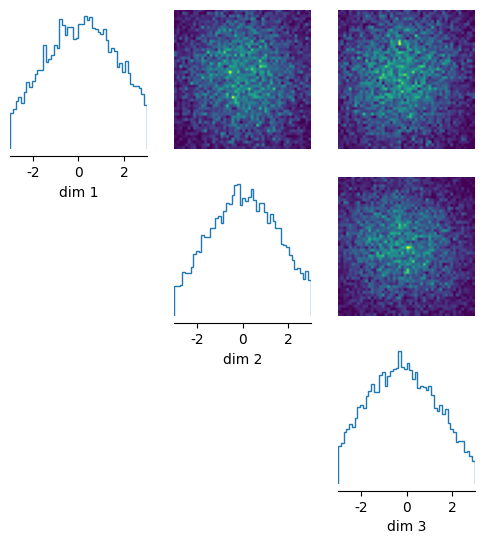

In [6]:
posterior_samples = posterior.sample((10000,), x=true_data)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[-3, 3], [-3, 3], [-3, 3]], figsize=(6, 6)
)

## It always outputs 0...

# Try changing the RNN to L=1000, N=1

In [12]:
toy_tensor = true_data.unsqueeze(0)
toy_tensor.shape

torch.Size([1, 1000, 6])

In [13]:
toy_tensor.view(toy_tensor.size(0), toy_tensor.size(1), 6)
toy_tensor.shape

torch.Size([1, 1000, 6])

In [19]:
toy_tensor.reshape(100, 10, 6)


tensor([[[  0.0000,   1.0000,   0.0000,   3.0000,   0.0000,   2.0000],
         [  8.9123,   1.3648,  12.9051,   3.4811,  42.9083,   4.0501],
         [ 13.8703,   2.3506,  14.4150,   4.4862,  61.6269,   8.8289],
         ...,
         [ 18.5595,   8.3686,  10.3243,   7.5761,  54.2094,  29.5599],
         [ 18.4679,   9.3356,   9.5372,   7.7992,  50.3403,  31.7195],
         [ 18.3167,  10.1985,   8.8137,   7.9293,  46.6273,  33.3119]],

        [[ 18.1467,  10.9635,   8.1522,   7.9810,  43.1233,  34.4088],
         [ 17.9864,  11.6398,   7.5497,   7.9677,  39.8499,  35.0785],
         [ 17.8566,  12.2378,   7.0023,   7.9009,  36.8121,  35.3841],
         ...,
         [ 18.1101,  14.4456,   4.9675,   7.0783,  24.8688,  33.2348],
         [ 18.4022,  14.8080,   4.6781,   6.8630,  23.0382,  32.3480],
         [ 18.7902,  15.1684,   4.4215,   6.6422,  21.3610,  31.3789]],

        [[ 19.2795,  15.5363,   4.1955,   6.4195,  19.8240,  30.3491],
         [ 19.8752,  15.9208,   3.9983,   6.1

In [20]:
toytoy = toy_tensor.reshape(100, 10, 6)
toytoy[0]

tensor([[ 0.0000,  1.0000,  0.0000,  3.0000,  0.0000,  2.0000],
        [ 8.9123,  1.3648, 12.9051,  3.4811, 42.9083,  4.0501],
        [13.8703,  2.3506, 14.4150,  4.4862, 61.6269,  8.8289],
        [16.3817,  3.5827, 13.8872,  5.4118, 65.9082, 14.1319],
        [17.6640,  4.8708, 13.0085,  6.1776, 64.8548, 19.0367],
        [18.2848,  6.1233, 12.0773,  6.7831, 61.8437, 23.2642],
        [18.5303,  7.2958, 11.1738,  7.2433, 58.1225, 26.7618],
        [18.5595,  8.3686, 10.3243,  7.5761, 54.2094, 29.5599],
        [18.4679,  9.3356,  9.5372,  7.7992, 50.3403, 31.7195],
        [18.3167, 10.1985,  8.8137,  7.9293, 46.6273, 33.3119]])

In [114]:
# Try changing the RNN to L=10, N=100, batch size and sequence length tradeoff?
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=False) #We are not specifying a batch size
        self.linear = nn.Linear(hidden_size, output_size)

                                                       #The middle value needs to be the length, in this case 1000, or input.size(0) (try with true_data)
                                                        #1 is the number of layers
                                                        #Actually prepare for sbi adds a batch_size, so x.shape is (1, 1000, 6)
    def forward(self, x):
        h = torch.zeros(1, 1000, self.hidden_size)
        gru_out, hn = self.gru(
            x, h)
        output = self.linear(gru_out[:, -1, :]) # It is outputting the last hidden state (timepoint 1000) for each GRU unit!
        return output

# Example usage
input_size = 6 #Needs to be the same as input.size(-1)
output_size = 25
hidden_size = 100
embedding_net = RNN(input_size, hidden_size, output_size)


In [89]:
#Code simulator and everything else as always
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the model
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, k2, k3 = params

    dm1dt = -m1 + (10 ** 3 / (1 + (10 ** k1 * p2) ** 2)) + 1
    dp1dt = -10 ** 0 * (p1 - m1)

    dm2dt = -m2 + (10 ** 3 / (1 + (10 ** k2 * p3) ** 2)) + 1
    dp2dt = -10 ** 0 * (p2 - m2)

    dm3dt = -m3 + (10 ** 3 / (1 + (10 ** k3 * p1) ** 2)) + 1
    dp3dt = -10 ** 0 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

#Define true parameters
true_params = np.array([
    0, 0, 0  # first set of odes
])

num_timesteps = 1000  # Number of time steps for simulation

num_dim = 3
num_timesteps = 1000
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))
num_trajectories = 6

#INVERSE! 6X1000!

def simulator(parameter_set):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    traj = torch.zeros((num_timesteps, num_trajectories))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[timestep, i] = solution[timestep][i]
    return traj

true_data = simulator(true_params)
true_data.shape

torch.Size([1000, 6])

In [24]:
true_data.shape

torch.Size([1000, 6])

In [ ]:
print(true_data.size(0), true_data.size(-1))

1000 6


In [90]:
# set prior distribution for the parameters
num_dim = 3
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))

# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)

In [115]:
# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(
    model="mdn", embedding_net=embedding_net, hidden_features=25, num_transforms=2
)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)

In [92]:
# run the inference procedure on one round and 10000 simulated data points
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=10)

Running 10 simulations.:   0%|          | 0/10 [00:00<?, ?it/s]

In [116]:
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 416 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

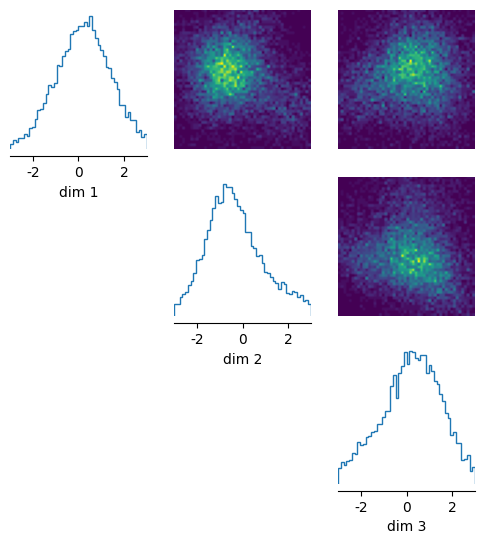

In [86]:
posterior_samples = posterior.sample((10000,), x=true_data)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[-3, 3], [-3, 3], [-3, 3]], figsize=(6, 6)
)

# Just try with flattened input... unbatched... GRU should work...

In [121]:
#Code simulator and everything else as always
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the model
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, k2, k3 = params

    dm1dt = -m1 + (10 ** 3 / (1 + (10 ** k1 * p2) ** 2)) + 1
    dp1dt = -10 ** 0 * (p1 - m1)

    dm2dt = -m2 + (10 ** 3 / (1 + (10 ** k2 * p3) ** 2)) + 1
    dp2dt = -10 ** 0 * (p2 - m2)

    dm3dt = -m3 + (10 ** 3 / (1 + (10 ** k3 * p1) ** 2)) + 1
    dp3dt = -10 ** 0 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

#Define true parameters
true_params = np.array([
    0, 0, 0  # first set of odes
])

num_timesteps = 1000  # Number of time steps for simulation

num_dim = 3
num_timesteps = 1000
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))
num_trajectories = 6

#INVERSE! 6X1000!

def simulator(parameter_set):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    traj = torch.zeros((num_trajectories, num_timesteps))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[i, timestep] = solution[timestep][i]
    true_list = []
    for tra in traj: #Erase this loop if we want 6x1000
        for timepoint in tra:
            true_list.append(timepoint)
    true_tensor = torch.Tensor(true_list)
    return true_tensor

true_data = simulator(true_params)
true_data.shape

torch.Size([6000])

In [254]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=False) #We are not specifying a batch size
        self.linear = nn.Linear(hidden_size, output_size)

                                                       #The middle value needs to be the length, in this case 1000, or input.size(0) (try with true_data)
                                                        #1 is the number of layers
                                                        #Actually prepare for sbi adds a batch_size, so x.shape is (1, 1000, 6)
    def forward(self, x):
        h = torch.zeros(1, self.hidden_size)
        gru_out, hn = self.gru(
            x, h)
        output = self.linear(gru_out[:, :]) # It is outputting the last hidden state (timepoint 1000) for each GRU unit!
        return output

# Example usage
input_size = 6000 #Needs to be the same as input.size(-1)
output_size = 25
hidden_size = 100
embedding_net = RNN(input_size, hidden_size, output_size)


In [ ]:
true_data.shape

torch.Size([1000, 6])

In [ ]:
print(true_data.size(0), true_data.size(-1))

1000 6


In [255]:
# set prior distribution for the parameters
num_dim = 3
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))

# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)

In [256]:
# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(
    model="mdn", embedding_net=embedding_net, hidden_features=25, num_transforms=2
)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)

In [257]:
# run the inference procedure on one round and 10000 simulated data points
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=10)

Running 10 simulations.:   0%|          | 0/10 [00:00<?, ?it/s]

In [258]:
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)

ValueError: GRU: Expected input to be 2D or 3D, got 4D instead

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

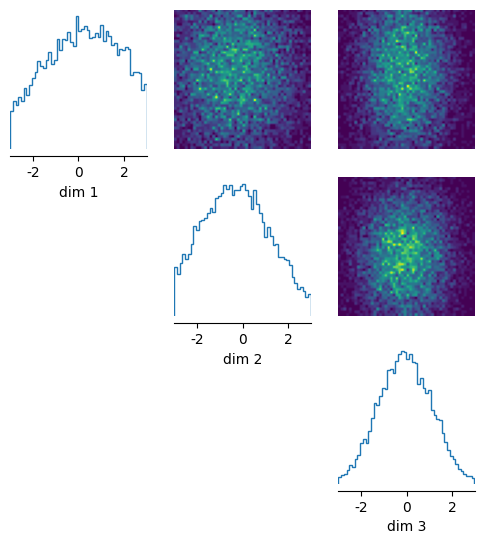

In [136]:
posterior_samples = posterior.sample((10000,), x=true_data)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[-3, 3], [-3, 3], [-3, 3]], figsize=(6, 6)
)

## Try figure out the inputs/outputs of function

When data is 1D we get a 25-dimensional embedding!

In [143]:
true_data
toy_1d = true_data.unsqueeze(0)

In [140]:
hidden_size=100
input_size=6000
gru = nn.GRU(input_size, hidden_size, batch_first=False)
linear = nn.Linear(hidden_size, output_size)

In [144]:
h = torch.zeros(1, 100)
gru_out, hn = gru(toy_1d, h)
output = linear(gru_out[:, :])
output.shape

torch.Size([1, 25])

When data is 6x1000 we also get a 25-dimensional embedding!

In [7]:
def simulator(parameter_set):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    traj = torch.zeros((num_timesteps, num_trajectories))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[timestep, i] = solution[timestep][i]
    return traj

true_data2 = simulator(true_params)
true_data2.shape

torch.Size([1000, 6])

In [8]:
toy_6dim = true_data2.unsqueeze(0)
toy_6dim.shape

torch.Size([1, 1000, 6])

In [147]:
toy_6dim

tensor([[[  0.0000,   1.0000,   0.0000,   3.0000,   0.0000,   2.0000],
         [  8.9123,   1.3648,  12.9051,   3.4811,  42.9083,   4.0501],
         [ 13.8703,   2.3506,  14.4150,   4.4862,  61.6269,   8.8289],
         ...,
         [ 46.9959, 113.7526,  56.8882,  25.9989,   1.2610,   2.7314],
         [ 42.7398, 107.1846,  63.3755,  29.2513,   1.2439,   2.5905],
         [ 38.8630, 100.8554,  70.3635,  32.8362,   1.2295,   2.4615]]])

In [11]:
hidden_size=100
input_size=6
gru = nn.GRU(input_size, hidden_size, batch_first=False)
linear = nn.Linear(hidden_size, output_size)

In [12]:
h = torch.zeros(1, 1000, 100)
gru_out, hn = gru(toy_6dim, h)
output = linear(gru_out[:,-1, :])
output.shape

torch.Size([1, 25])

In [212]:
output

tensor([[-0.2694, -0.1480,  0.0611,  0.1230,  0.6200,  0.1180, -0.5918, -0.0999,
          0.1658,  0.0414,  0.0048,  0.6394, -0.1191, -0.2468, -0.0178,  0.2650,
          0.4996, -0.1930,  0.3569,  0.0031,  0.5506, -0.6717, -0.4459,  0.3989,
          0.5723]], grad_fn=<AddmmBackward0>)

Now, all this is with batch_size = 1000 because batch_first = False... What about batch_first = True?

In [261]:
hidden_size=100
input_size=6
output_size=25
gru = nn.GRU(input_size, hidden_size, batch_first=True)
linear = nn.Linear(hidden_size, output_size)

In [9]:
h = torch.zeros(1, 1, 100)
gru_out, hn = gru(toy_6dim, h)
output = linear(gru_out[:,-1, :])
output.shape

torch.Size([1, 25])

In [263]:
output

tensor([[ 0.1936,  0.4671, -0.7828, -0.5686,  0.1036,  0.6322,  0.2601, -0.6225,
          0.7973,  0.0210, -0.1595, -0.5193, -0.6185, -0.4141,  0.0025, -0.4227,
         -1.1154, -0.3388, -0.1364,  0.0111,  0.2940, -0.5689, -0.2356,  0.2934,
          0.0153]], grad_fn=<AddmmBackward0>)

What about a different batch_size?

In [14]:
toy_6dim_reshaped = toy_6dim.view(100,10,6)
toy_6dim_reshaped.shape

torch.Size([100, 10, 6])

In [15]:
hidden_size=100
input_size=6
output_size=25
gru = nn.GRU(input_size, hidden_size, batch_first=True)
linear = nn.Linear(hidden_size, output_size)

In [16]:
h = torch.zeros(1, 100, 100)
gru_out, hn = gru(toy_6dim_reshaped, h)
output = linear(gru_out[:,-1, :])
output.shape

torch.Size([100, 25])

In [163]:
gru_out.shape

torch.Size([100, 10, 100])

If batch size of not the complete dataset or 1, we end up with embeddings for each batch, in the above case 100. We need a pooling operation.

In [6]:
hidden_size=100
input_size=6
output_size=25
gru = nn.GRU(input_size, hidden_size, batch_first=True)
linear = nn.Linear(hidden_size, output_size)
h = torch.zeros(1, 100, 100)
gru_out, hn = gru(toy_6dim_reshaped, h)
raw_out = torch.mean(linear(gru_out[:,-1, :]), dim=0)
raw_out

NameError: name 'toy_6dim_reshaped' is not defined

In [ ]:
output

In [5]:
output

NameError: name 'output' is not defined

### What about adaptive avg pooling?

In [279]:

# target output size of 5
m = nn.AdaptiveAvgPool1d(5)
input = torch.randn(1, 64, 8)
output = m(input)
output.shape

torch.Size([1, 64, 5])

In [282]:
hidden_size=100
input_size=6
output_size=25
gru = nn.GRU(input_size, hidden_size, batch_first=True)
linear = nn.Linear(hidden_size, output_size)
h = torch.zeros(1, 100, 100)
gru_out, hn = gru(toy_6dim_reshaped, h)
raw_out = linear(gru_out[:,-1, :])
trans = torch.transpose(raw_out, 0, 1)
output = nn.AdaptiveAvgPool1d(trans)
result = nn
output.shape

AttributeError: 'AdaptiveAvgPool1d' object has no attribute 'shape'

Try this pooling in a toy example:

In [270]:
#Code simulator and everything else as always
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the model
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, k2, k3 = params

    dm1dt = -m1 + (10 ** 3 / (1 + (10 ** k1 * p2) ** 2)) + 1
    dp1dt = -10 ** 0 * (p1 - m1)

    dm2dt = -m2 + (10 ** 3 / (1 + (10 ** k2 * p3) ** 2)) + 1
    dp2dt = -10 ** 0 * (p2 - m2)

    dm3dt = -m3 + (10 ** 3 / (1 + (10 ** k3 * p1) ** 2)) + 1
    dp3dt = -10 ** 0 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

#Define true parameters
true_params = np.array([
    0, 0, 0  # first set of odes
])

num_timesteps = 1000  # Number of time steps for simulation

num_dim = 3
num_timesteps = 1000
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))
num_trajectories = 6

#INVERSE! 6X1000!

def simulator(parameter_set):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    traj = torch.zeros((num_timesteps, num_trajectories))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[timestep, i] = solution[timestep][i]
    return traj

true_data = simulator(true_params)
true_data.shape

torch.Size([1000, 6])

In [269]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True) #batch_size of 100
        self.linear = nn.Linear(hidden_size, output_size)

                                                       #The middle value needs to be the length, in this case 1000, or input.size(0) (try with true_data)
                                                        #1 is the number of layers
                                                        #Actually prepare for sbi adds a batch_size, so x.shape is (1, 1000, 6)
    def forward(self, x):
        xb = x.view(100,10,6) #12?
        h = torch.zeros(1, 100, self.hidden_size)
        gru_out, hn = self.gru(
            xb, h)
        output = torch.mean(linear(gru_out[:,-1, :]), dim=0)
        return output

# Example usage
input_size = 6 #Needs to be the same as input.size(-1)
output_size = 25
hidden_size = 100
embedding_net = RNN(input_size, hidden_size, output_size)


In [271]:
# set prior distribution for the parameters
num_dim = 3
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))

# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)

In [275]:
# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(
    model="mdn", embedding_net=embedding_net, hidden_features=10, num_transforms=2
)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)

In [273]:
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=10)

Running 10 simulations.:   0%|          | 0/10 [00:00<?, ?it/s]

In [276]:
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)

RuntimeError: (RuntimeError("shape '[100, 10, 6]' is invalid for input of size 12000"), 'Debug hint: The simulated data x has 2 dimensions.\n            With default settings, sbi cannot deal with multidimensional simulations.\n            Make sure to use an embedding net that reduces the dimensionality, e.g., a\n            CNN in case of images, or change the simulator to return one-dimensional x.\n            ')

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

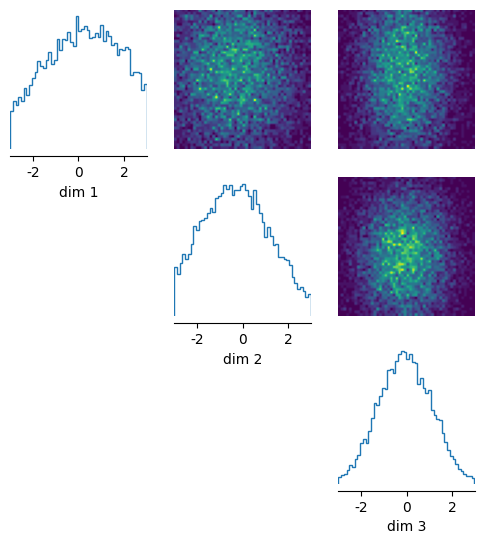

In [ ]:
posterior_samples = posterior.sample((10000,), x=true_data)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[-3, 3], [-3, 3], [-3, 3]], figsize=(6, 6)
)

# PCA to check whether embeddings actually work...

In [224]:
true_params = np.array([
    0, 0, 0  # first set of odes
])
close_params = np.array([
    0.1, 0.05, 0  # first set of odes
])
close_params2 = np.array([
    -0.02, 0.03, 0.1  # first set of odes
])
close_params3 = np.array([
    0.02, -0.04, -0.01  # first set of odes
])
far_params = np.array([
    1, 0.8, -0.7  # first set of odes
])
far_params2 = np.array([
    1.5, -0.8, 1.7  # first set of odes
])

In [214]:
def simulator(parameter_set):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    traj = torch.zeros((num_timesteps, num_trajectories))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[timestep, i] = solution[timestep][i]
    out = traj.unsqueeze(0)
    return out

toy_6dim = simulator(true_params)
toy_6dim.shape

torch.Size([1, 1000, 6])

In [221]:
def embedding(trajectory):
    hidden_size=100
    input_size=6
    output_size=25
    gru = nn.GRU(input_size, hidden_size, batch_first=False)
    linear = nn.Linear(hidden_size, output_size)
    h = torch.zeros(1, 1000, 100)
    gru_out, hn = gru(trajectory, h)
    output = linear(gru_out[:,-1, :])
    return output

In [222]:
emb_1 = embedding(toy_6dim)

In [223]:
emb_1.shape

torch.Size([1, 25])

In [241]:
c1 = embedding(simulator(close_params)).detach().numpy()
c2 = embedding(simulator(close_params2)).detach().numpy()
c3 = embedding(simulator(close_params3)).detach().numpy()
f1 = embedding(simulator(far_params)).detach().numpy()
f2 = embedding(simulator(far_params2)).detach().numpy()

In [240]:
t0 = emb_1.detach().numpy()

In [242]:
toy_embeddings = np.array([t0, c1, c2, c3, f1, f2])

In [250]:
embeddings = toy_embeddings.reshape(6,25)

In [251]:
embeddings.shape

(6, 25)

# Try PCA to check whether it actually works



Shape of transformed data: (6, 6)


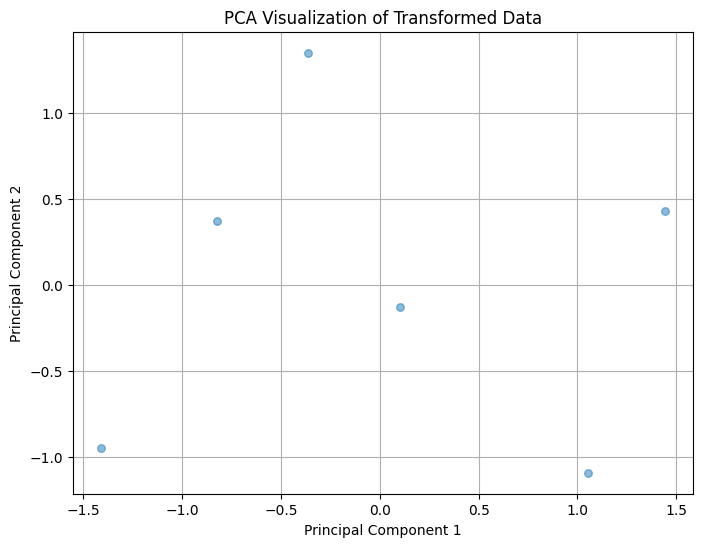

In [253]:
from sklearn.decomposition import PCA
import numpy as np

# Number of components (desired output dimensionality)
n_components = 6

# Create an instance of PCA
pca = PCA(n_components=n_components)

# Fit PCA on the data and transform it to the lower-dimensional space
lower_dim_data = pca.fit_transform(embeddings)

# Print the shape of the transformed data
print("Shape of transformed data:", lower_dim_data.shape)

import matplotlib.pyplot as plt

# Plot the transformed data
plt.figure(figsize=(8, 6))
plt.scatter(lower_dim_data[:, 0], lower_dim_data[:, 1], s=30, alpha=0.5)
plt.title('PCA Visualization of Transformed Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


# Try again

In [4]:
#Code simulator and everything else as always
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the model
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, k2, k3 = params

    dm1dt = -m1 + (10 ** 3 / (1 + (10 ** k1 * p2) ** 2)) + 1
    dp1dt = -10 ** 0 * (p1 - m1)

    dm2dt = -m2 + (10 ** 3 / (1 + (10 ** k2 * p3) ** 2)) + 1
    dp2dt = -10 ** 0 * (p2 - m2)

    dm3dt = -m3 + (10 ** 3 / (1 + (10 ** k3 * p1) ** 2)) + 1
    dp3dt = -10 ** 0 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

#Define true parameters
true_params = np.array([
    0, 0, 0  # first set of odes
])

num_timesteps = 1000  # Number of time steps for simulation

num_dim = 3
num_timesteps = 1000
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))
num_trajectories = 6

#INVERSE! 6X1000!

def simulator(parameter_set):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    traj = torch.zeros((num_timesteps, num_trajectories))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[timestep, i] = solution[timestep][i]
    return traj

true_data = simulator(true_params)
true_data.shape

torch.Size([1000, 6])

In [ ]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True) #batch_size of 100
        self.linear = nn.Linear(hidden_size, output_size)
        self.pool = nn.AdaptiveAvgPool1d(output_size)

                                                       #The middle value needs to be the length, in this case 1000, or input.size(0) (try with true_data)
                                                        #1 is the number of layers
                                                        #Actually prepare for sbi adds a batch_size, so x.shape is (1, 1000, 6)
    def forward(self, x):
        xb = x.view(100,10,6) #12?
        h = torch.zeros(1, 100, self.hidden_size)
        gru_out, hn = self.gru(
            xb, h)
        output = self.linear(gru_out[:,-1, :])
        result = self.pool(output)
        return result

# Example usage
input_size = 6 #Needs to be the same as input.size(-1)
output_size = 25
hidden_size = 100
embedding_net = RNN(input_size, hidden_size, output_size)


In [17]:
output

tensor([[ 0.1005, -0.2226,  0.5280,  ..., -0.6327, -0.3792, -0.7269],
        [-0.0582, -0.0544,  0.4063,  ..., -0.8317, -0.4285, -0.7134],
        [-0.1679, -0.0131,  0.1809,  ..., -1.0424, -0.5320, -0.6070],
        ...,
        [ 0.7748, -0.0593,  0.4477,  ..., -0.9969,  0.1195, -0.0969],
        [ 0.8679, -0.2788,  0.3752,  ..., -1.2884,  0.2730, -0.2544],
        [ 0.1761,  0.2504,  0.4780,  ..., -0.9751, -0.2881,  0.0023]],
       grad_fn=<AddmmBackward0>)

In [24]:
m = nn.AdaptiveAvgPool1d(1)
m(torch.transpose(output, 1, 0)).shape

torch.Size([25, 1])

In [ ]:
# set prior distribution for the parameters
num_dim = 3
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))

# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)

In [ ]:
# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(
    model="mdn", embedding_net=embedding_net, hidden_features=10, num_transforms=2
)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)

In [ ]:
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=10)

Running 10 simulations.:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)

RuntimeError: (RuntimeError("shape '[100, 10, 6]' is invalid for input of size 12000"), 'Debug hint: The simulated data x has 2 dimensions.\n            With default settings, sbi cannot deal with multidimensional simulations.\n            Make sure to use an embedding net that reduces the dimensionality, e.g., a\n            CNN in case of images, or change the simulator to return one-dimensional x.\n            ')